# Análise de Churn

Este é um case sobre análise de dados para um dataset sobre assinaturas de serviço da petlove. O objetivo é descobrir fatores que causam o churn para este serviço.

### Aqui importamos as bibliotecas necessárias para o código

Como o dataset é pequeno, pode ser feito utilizando pandas para análise. Caso fosse um dataset maior, uma boa opção seria polars ou pyspark

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

### Leitura do dataset pelo pandas

In [121]:
df = pd.read_csv('data-test-analytics_5.csv', delimiter=',')

### Etapa de pré processamento

Nesta etapa o objetivo é corrigir os defeitos do conjunto de dados que possam impedir ou diminuir a qualidade da análise.

Aqui podemos ver quais colunas são tratadas como objeto (string) e quais são colunas numéricas. E também vemos quais colunas possuem valores nulos. No caso apenas deleted_at possui valores nulos, já que nem todas as contas estão como canceladas.

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   created_at          10000 non-null  object 
 2   updated_at          10000 non-null  object 
 3   deleted_at          505 non-null    object 
 4   name_hash           10000 non-null  object 
 5   email_hash          10000 non-null  object 
 6   address_hash        10000 non-null  object 
 7   birth_date          10000 non-null  object 
 8   status              10000 non-null  object 
 9   version             10000 non-null  object 
 10  city                10000 non-null  object 
 11  state               10000 non-null  object 
 12  neighborhood        10000 non-null  object 
 13  last_date_purchase  10000 non-null  object 
 14  average_ticket      10000 non-null  float64
 15  items_quantity      10000 non-null  int64  
 16  all_r

Transformando as datas para datetime

In [123]:
date_cols = ['created_at', 'updated_at', 'deleted_at', 'birth_date', 'last_date_purchase',]
for col in date_cols:
  df[col] = pd.to_datetime(df[col])
  df[col] = (df[col] - datetime(1970, 1, 1)).dt.total_seconds()

/tmp/ipykernel_10020/3107871894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_10020/3107871894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_10020/3107871894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_10020/3107871894.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df

Para esta análise, não é interessante manter as colunas com hash, já que possuem valores criptografados que não podem ser assimilados. Para distinguir cada usuário, vamos usar o campo ID e suas outras informações pessoais.

In [124]:
hash_cols = ['name_hash', 'email_hash', 'address_hash']
for col in hash_cols:
  del(df[col])

aplicar one hot encoding para as colunas categóricas como status e marketing_source

In [125]:
df = pd.get_dummies(df, columns=['status'], prefix='status', dtype=int)
df = pd.get_dummies(df, columns=['marketing_source'], prefix='source', dtype=int)

A coluna sobre cidades é um pouco complicada de se trabalhar por ser um dado categórico e ao mesmo tempo possuir uma variedade muito grande, o que impede de usar o one hot encoding. Existem 2406 cidades listadas neste dataset.

In [126]:
print("número de cidades:")
print(df.city.drop_duplicates().count())

número de cidades:
2406


Após as mudanças, existem 24 colunas

In [128]:
df.shape

(10000, 24)

In [129]:
df.columns

Index(['id', 'created_at', 'updated_at', 'deleted_at', 'birth_date', 'version',
       'city', 'state', 'neighborhood', 'last_date_purchase', 'average_ticket',
       'items_quantity', 'all_revenue', 'all_orders', 'recency',
       'status_active', 'status_canceled', 'status_paused', 'source_crm',
       'source_direct', 'source_none', 'source_organic_search',
       'source_paid_search', 'source_telegram_whatsapp'],
      dtype='object')

Aqui separo as colunas ideais para utilizar um min-max scaller e criar um outro dataframe.

In [133]:
colunas_corr = ['created_at', 'updated_at', 'deleted_at', 'birth_date', 'last_date_purchase',
                 'average_ticket', 'items_quantity', 'all_revenue', 'all_orders', 'recency', 'status_active', 'status_canceled',
                 'status_paused', 'source_crm', 'source_direct', 'source_none', 'source_organic_search', 'source_paid_search',
                   'source_telegram_whatsapp']
df_separated = df[colunas_corr]

In [138]:
scaler = MinMaxScaler()
df_separated = pd.DataFrame(scaler.fit_transform(df_separated), columns=df[colunas_corr].columns)

### Análise dos dados

Vamos analisar a correlação entre as colunas selecionadas no pre processamento

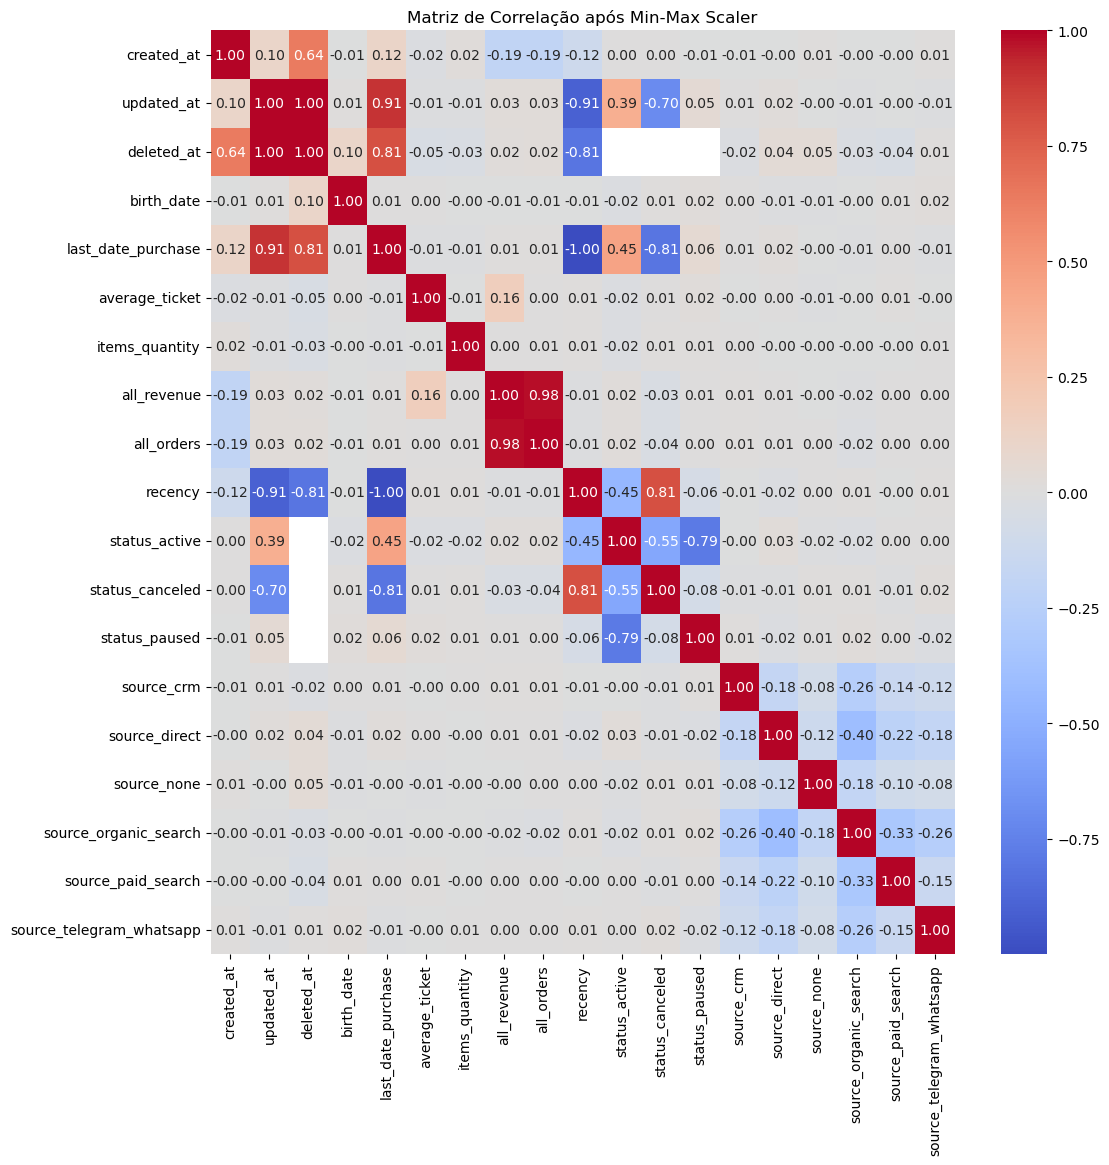

In [140]:
corr = df_separated.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação após Min-Max Scaler')
plt.show()

Após vermos o mapa de correlação, podemos tirar alguns insights sobre:

status_active tem suas maiores correlações com: recency, last_date_purchase e updated_at.

status_canceled tem suas maiores correlações com: recency, last_date_purchase e updated_at.

status_paused: Não tem grandes correlações no geral.


Aqui vamos separar as relações destacadas no markdown anterior:

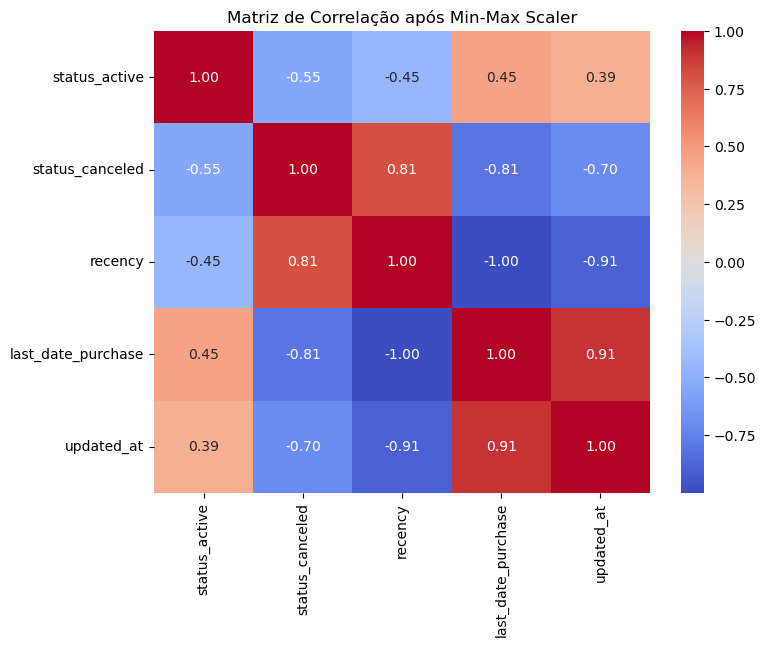

In [149]:
df_separated2 = df_separated[['status_active', 'status_canceled', 'recency', 'last_date_purchase', 'updated_at']]
corr = df_separated2.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação após Min-Max Scaler')
plt.show()


Aqui vamos analisar as distribuições do dataset

É possível ver que existe um padrão nos clientes ativos. A maioria dos clientes ativos não ficam longos períodos sem fazer compras. O que pode indicar que se um cliente está passando de um item limite sem retornar a comprar, ele tem alta chance de cancelar a assinatura

/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if

<AxesSubplot:xlabel='recency', ylabel='Count'>

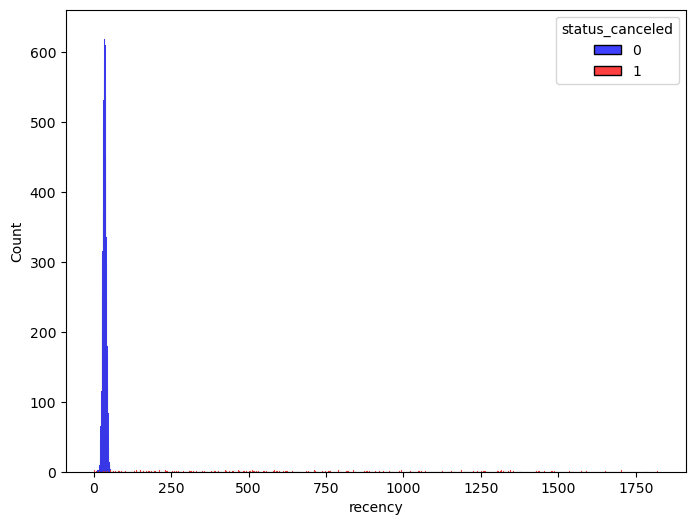

In [157]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='recency', hue='status_canceled', multiple='stack', bins=range(df['recency'].min(), df['recency'].max() + 2), palette={0: 'blue', 1: 'red'})

In [150]:
df_canceled_true = df[df['status_canceled'] == 1]
df_canceled_false = df[df['status_canceled'] == 0]

In [151]:
df_canceled_true = df[df['status_active'] == 1]
df_canceled_false = df[df['status_active'] == 0]

In [152]:
df_canceled_true = df[df['status_paused'] == 1]
df_canceled_false = df[df['status_paused'] == 0]

Neste próximo gráfico, vamos analisar a curva de histograma dos usuários que não cancelaram a assinatura em relação a recency.

Podemos notar que segue uma distribuição normal.

/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vitor/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<AxesSubplot:xlabel='recency', ylabel='Count'>

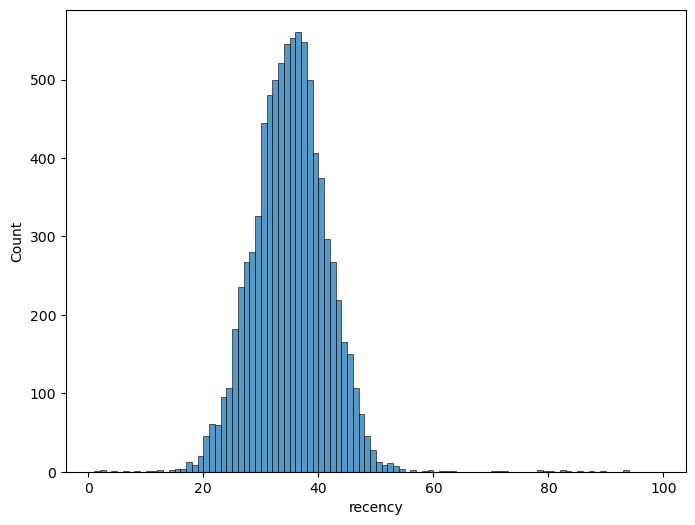

In [167]:
plt.figure(figsize=(8, 6))
sns.histplot(data=df_canceled_false, x='recency', bins=range(df_canceled_false['recency'].min(), 100))

In [168]:
moda_recency = df_canceled_false['recency'].mode()
print("Moda de recency:", moda_recency)
media_recency = df_canceled_false['recency'].mean()
print("Média de recency:", media_recency)
desvio_padrao_recency = df_canceled_false['recency'].std()
print("Desvio Padrão de recency:", desvio_padrao_recency)


Moda de recency: 0    36
Name: recency, dtype: int64
Média de recency: 70.68800531620334
Desvio Padrão de recency: 184.58138945842126


Após colher os dados da moda, média e desvio padrão, podemos concluir que apartir do tempo 36 (moda) as chances do cliente cancelar a assinatura passam a serem crescentes. Olhando o gráfico, um insight que podemos tirar é que perto de 45, passa a ser crítico e a chance do cancelamento da assinatura passa a ser muito alta.